# Data Eng: Week 4 Practical

In this practical you will add an ingestion pipeline to write out the raw daa to a posgres database, including ingestion metadata and schema checks. You will also modify the pipeline from the practical of week 3 to extract the raw data from postgres, before transforming and loading the aggregated data.

---

## Overview

In this practical, we want to separate our steps to create 2 pipeines:
1. An ingestion pipeline where we load the raw data into a postgres database (our data lake)
2. A pipeline to extract data from postgres, create our prepared / aggregated data and load it into a SQLite database where it may be used by analysts

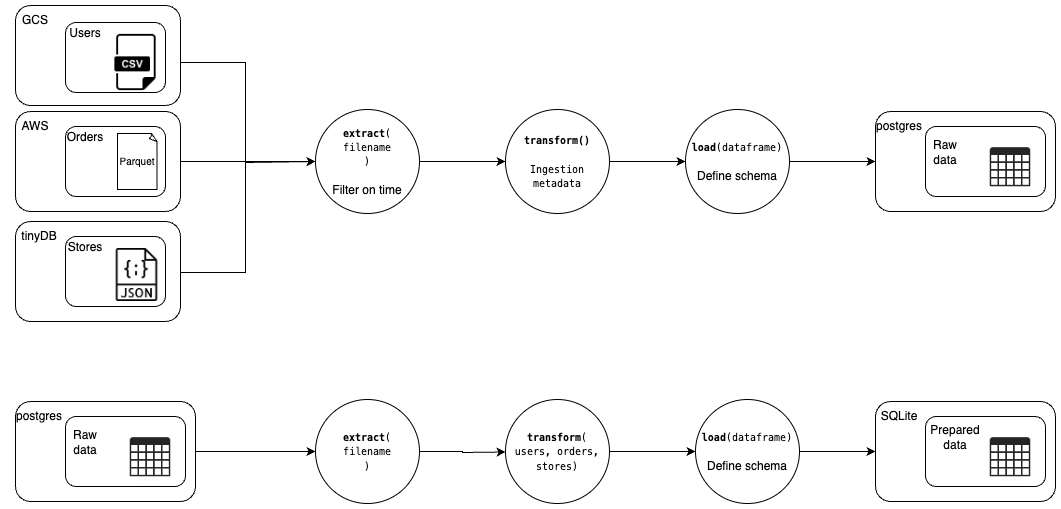

In [ ]:
# setup  your python environment by installing the necessary packages

! pip install --quiet pandas boto3 s3fs pyarrow
! pip install tinydb

In [ ]:
#
# Creates stores.json as local TinyDB and inserts store data
# DO NOT EDIT
#

from tinydb import TinyDB, Query
# Create or load the TinyDB database (the file will be saved locally in Colab's environment)
db = TinyDB('stores.json')

# Insert store data
stores_data = {
    "1": {
        "name": "Downtown Grocery",
        "address": "123 Main St, Somerset West, Western Cape",
        "hours": "8am – 9pm"
    },
    "2": {
        "name": "Westside Market",
        "address": "123 Dorp St, Stellenbosch, Western Cape",
        "hours": "7am – 10pm"
    },
    "3": {
        "name": "DeWaterGat Market",
        "address": "341 Kerk St, Port Elizabeth, Eastern Cape",
        "hours": "9am – 6pm"
    },
       "4": {
        "name": "The Diamond Market",
        "address": "632 Carters rd, Kimberley, Northern Cape",
        "hours": "9am – 5pm"
    },
       "5": {
        "name": "East London Market",
        "address": "478 Wilsonia St, East London, Eastern Cape",
        "hours": "8am – 6pm"
    }

}

# Insert the stores data into the database
for store_id, store_info in stores_data.items():
    db.insert({'store_id': store_id, **store_info})


In [ ]:
# import the python packages
import pandas as pd

# import package to read from google cloud storage
from google.cloud import storage
from io import StringIO

import numpy as np
import sqlite3

## Pipeline 1: Extract
Our gcs_extract() function remains the same as in Weeks 2 & 3.

In [ ]:
def gcs_extract(bucket_name: str, filename: str,  delimiter: str=',') -> pd.DataFrame:
  """
  extract data from a csv file in a GCS bucket and structure it into a pandas dataframe

  Args:
     bucket_name (str): name of the bucket
     filename (str): name of the file
     delimiter (str): default ','

  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by the csv file
  """

  try:
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name=bucket_name)
    blob = bucket.blob(filename)
    data = blob.download_as_text()
    # Use StringIO to read the string data into a pandas DataFrame
    df = pd.read_csv(StringIO(data))
    return df
  except FileNotFoundError:
    # Handle the case where the file is not found in GCS
    print(f"Error: File '{filename}' not found.")
    return None

In [ ]:
df_users = gcs_extract('bdt-beam','users_v.csv')
df_users.head()

Our s3_extract() function remains the same as in Weeks 2 & 3.

In [ ]:
def s3_extract(bucket_name: str, filename: str) -> pd.DataFrame:
  """
  extract data from a file in an S3 bucket and structure it into a pandas dataframe

  Args:
     bucket_name (str): name of the bucket
     filename (str): name of the file

  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by the csv file
  """

  try:
    s3_path =  's3://' + bucket_name + '/' + filename
    # Read the Parquet file into a pandas DataFrame and filter for 2000-01-02 only
    df = pd.read_parquet(s3_path, filters=[('date_purchased', '==', '2000-01-02')])
    return df
  except FileNotFoundError:
    # Handle the case where the file is not found in S3
    print(f"Error: File '{filename}' not found.")
    return None

In [ ]:
df_orders = s3_extract('dev-training-analytics','df_orders.parquet')
df_orders.head()

Our tinydb_extract() function remains the same as in Week 3.

In [ ]:
def tinydb_extract(database_name: str) -> pd.DataFrame:
  """
  extract data from a file in a TinyDB instance and structure it into a pandas dataframe

  Args:
     database_name (str): name of the database
  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by the database
  """

  try:
    # Load the stores data from TinyDB
    db = TinyDB(database_name)
    stores_data = db.all()
    # Convert the stores data into a DataFrame
    df = pd.DataFrame(stores_data)
    return df
  except FileNotFoundError:
    # Handle the case where the file is not found in S3
    print(f"Error: File '{database_name}' not found.")
    return None

In [ ]:
df_stores = tinydb_extract('stores.json')
df_stores.head()

## Pipeline 1: Transform

We don't want to do any significant transformations to our raw data before loading it to our database. However, it is useful to add some metadata to the data before loading. Add an `_ingest_time` field to each of the 3 sources to record when the ingestion was done.

_HINT: You may need to add some additional packages to your import cell at the top of the notebook._

In [ ]:
###
# this function is to be completed by the student
##
def add_metadata(df: pd.DataFrame) -> pd.DataFrame:
  """
  add ingestion metadata to a pandas dataframe

  Args:
     df (pd.DataFrame): A pandas dataframe
  Return:
     pandas.DataFrame: A pandas dataframe with added metadata
  """

  ## --- begin: student to complete subsequent code

  ### --- end

In [ ]:
## --- begin: student to complete subsequent code

# Complete the function call to add _ingest_time to each of the 3 sources
df_users = add_metadata()
df_orders = add_metadata()
df_stores = add_metadata()
# --- end:

## Pipeline 1: Load

Create a load_raw() function to load the raw data into a postgres database as a daily sharded table so that we can maintain history and idompotency (i.e. table names should be `tablename_YYYYMMDD`). Also include a schema check before loading the data (i.e. only if the raw data matches the expected schema, should it be written to the database). If there is a schema mismatch, log an error (in reality, this would trigger an alert and the data would likely be written to an error bucket).

The raw data, including the added `_ingest_time` metadata, should have the following schemas (_HINT: you may need to do some field casting as part of your Transform step. For the purpose of this practical, you may just do this as an ad hoc transformation step._):

`users_YYYYMMDD`
```
expected_schema = {
    'user_id':'int64',
    'name':'string',
    'gender':'string',
    'age':'int64',
    'address':'string',
    'date_joined':'datetime64[s]',
    '_ingest_time':'datetime64[s]',
}
```
`orders_YYYYMMDD`
```
expected_schema = {
    'order_no':'int64',
    'user_id':'int64',
    'product_list':'string',
    'date_purchased':'datetime64[s]',
    'store_id':'int64',
    '_ingest_time':'datetime64[s]',
}
```

`stores_YYYYMMDD`
```
expected_schema = {
    'store_id':'int64',
    'name':'string',
    'address':'string',
    'hours':'string',
    '_ingest_time':'datetime64[s]',
}
```

_HINT: You will need to create a new local postgres database and user - see [stackoverflow](https://stackoverflow.com/questions/61030755/connect-to-postresql-database-from-google-colab). There are various ways in which you can then connect to, and query this database, including SQLAlchemy - see [docs](https://docs.sqlalchemy.org/en/20/core/engines.html). You may also need to add some additional packages to your import cell at the top of the notebook_.

In [ ]:
## --- begin: student to complete subsequent code

# Start PostgreSQL service
# Create new postgresSQL service, user and databse
# Create engine to connect to database

### --- end

In [ ]:
###
# this function is to be completed by the student
##
def check_schema(df: pd.DataFrame, expected_schema: str):
  """
  check whether schema matches expected schema

  Args:
     df (pd.DataFrame): A pandas dataframe
     expected_schema (str): Expected schema for dataframe
  Return:
     bool: True/False whether schema matches
  """
  ## --- begin: student to complete subsequent code

  ### --- end

In [ ]:
###
# this function is to be completed by the student
##
def write_to_postgres(engine, df, expected_schema, table_name):
    """
  load data to postgres database if schema matches expected schema

  Args:
     engine: Engine to connect to postgres database
     df (pd.DataFrame): A pandas dataframe
     expected_schema (str): Expected schema for dataframe
     table_name (str): Name of table to be loaded
  Return:
     None
  """
    ## --- begin: student to complete subsequent code

    ### --- end

In [ ]:
## --- begin: student to complete subsequent code

# Define expected schema
# Cast data types

# Complete the function call to load users_YYYYMMDD
write_to_postgres()
# --- end:

In [ ]:
## --- begin: student to complete subsequent code

# Define expected schema
# Cast data types

# Complete the function call to load orders_YYYYMMDD
write_to_postgres()
# --- end:

In [ ]:
## --- begin: student to complete subsequent code

# Define expected schema
# Cast data types

# Complete the function call to load stores_YYYYMMDD
write_to_postgres()
# --- end:

## Pipeline 1
Run your pipeline end to end

In [ ]:
## --- begin: student to complete subsequent code

# Extract data

# Transform

# Load

# --- end:

Expected output of pipeline (when running your load function for relevant YYYYMMDD)
```
Schema matches.
DataFrame written to table 'users_YYYYMMDD'.

```

```
Schema matches.
DataFrame written to table 'orders_YYYYMMDD'.

```

```
Schema matches.
DataFrame written to table 'stores_YYYYMMDD'.

```

## Pipeline 2: Extract

Extract the data from the postgres database (today's shard) to be used in our aggregation pipeline.

In [ ]:
###
# this function is to be completed by the student
##
def read_from_postgres(engine, table_name) -> pd.DataFrame:
    """
  read data from postgres database into a pandas dataframe

  Args:
     engine: Engine to connect to postgres database
     table_name (str): Name of table to be extracted
  Return:
     A pandas dataframe
  """
    ## --- begin: student to complete subsequent code

    ### --- end

In [ ]:
## --- begin: student to complete subsequent code

# Complete the function call to load the data
df_users = read_from_postgres()
df_orders = read_from_postgres()
df_stores = read_from_postgres()

# --- end:

## Pipeline 2: Transform

Our transform() function remains the same as in Week 3.

In [ ]:
def transform(users: pd.DataFrame, orders: pd.DataFrame, stores: pd.DataFrame) -> pd.DataFrame:
  """
  Take three dataframes, and produce a dataset

  Args:
     users: a dataframe of user information
     orders: a dataframe of user orders
     stores: a dataframe of store information

  Return:
     pandas.DataFrame: A pandas dataframe with header as defined by user
     requirements
  """
  # Join users and orders as before
  joined = df_users.merge(df_orders,  on='user_id')

  # Extract the province value from the address of each store
  df_stores['province'] = df_stores['address'].apply(lambda x: x.split(',')[-1].strip())

  # Now join the stores table to the orders table
  df_stores.store_id = df_stores.store_id.astype('int64')
  joined_stores = joined.merge(df_stores[['store_id','province']], on='store_id')

  # Add the lotalty flag
  joined_stores.date_joined = pd.to_datetime(joined_stores['date_joined'])
  joined_stores.date_purchased = pd.to_datetime(joined_stores['date_purchased'])
  joined_stores['loyalty'] =  np.where(joined_stores['date_joined'].dt.year == joined_stores['date_purchased'].dt.year, True, False)

  # perform the groupby operation and be sure to subset - `count` will
  # count the purchases.
  df = joined_stores.groupby(['date_purchased','province','store_id','gender','loyalty'])['user_id'].count().rename('total_purchases')
  return df.reset_index()



In [ ]:
df_transform = transform(df_users, df_orders, df_stores)
df_transform.head()

### Load

Modify the load() function from Week 3 to load the aggregated data table into the local sqlite database as a daily sharded table so that we can maintain history and idompotency (i.e. table name should be sales_aggregated_YYYYMMDD).


In [ ]:
###
# this function is to be modified by the student
##
def load(transformed: pd.DataFrame, database_name: str, table_name: str) -> None:
  """
  Write the dataframe to a local sqlite db with specified schema

  Args:
    transformed: a dataframe with columns ['date_purchased','province','store_id', 'gender', 'loyalty', 'total_purchases']
    database_name: name for the local SQLite DB you are creating
    table_name: name of the table you are loading the data to
  Return:
    None
  """
  try:
    # Create a local SQLite database
    db_path = database_name
    conn = sqlite3.connect(db_path)

    # Convert your datetime to ISO 8601 format (YYYY-MM-DD HH:MM:SS) for loading to SQLite
    df_transform['date_purchased'] = df_transform['date_purchased'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Define schema and create table (if needed)
    schema = f'''
    CREATE TABLE IF NOT EXISTS {table_name} (
        date_purchased TEXT NOT NULL,
        province TEXT NOT NULL,
        store_id INTEGER NOT NULL,
        gender TEXT NOT NULL,
        loyalty TEXT NOT NULL,
        total_purchases INTEGER NOT NULL
    )
    '''
    conn.execute(schema)


    ## --- begin: student to modify subsequent code

    # Write the DataFrame to the SQLite database
    df_transform.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"DataFrame successfully written to '{table_name}' in database '{database_name}'.")

    ### --- end
  except Exception as e:
    # Handle any errors that might occur during writing
    print(f"Error writing DataFrame to databse: {e}")

In [ ]:
## --- begin: student to complete subsequent code

# Execute your load() function to load your data into the SQLite database
load()

# --- end:

## Pipeline

Run your pipeline end to end

Expected output (use `!head df_transform`):


| date_purchased | province | store_id | gender | loyalty | total_purchases |
| ------ | ------ | ------ | ------ | ------ | ------ |
| 2000-01-02 | Eastern Cape | 3 | male | False | 2 |
| 2000-01-02 | Eastern Cape | 5 | female | False | 1 |
| 2000-01-02 | Eastern Cape | 5 | male | False | 2 |
| 2000-01-02 | Northern Cape | 4 | male | False | 2 |
| 2000-01-02 | Northern Cape | 4 | male | True | 1 |
| 2000-01-02 | Western Cape | 1 | female | False | 1 |
| 2000-01-02 | Western Cape | 1 | male | True | 1 |
| 2000-01-02 | Western Cape | 2 | female | False | 2 |
| 2000-01-02 | Western Cape | 2 | male | False | 2 |




Expected output of pipeline (when running your load function)
```
DataFrame successfully written to 'sales_aggregated_20241013' in database 'local_sqlite_database.db'.

```

In [ ]:
## --- begin: student to complete subsequent code

# Extract data

# Transform

# Load

# --- end: